# Recurrent Neural Network
- Author : *Jinhong Du*

- Reference: 
    
    1. https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
    2. https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

# Content

1. [Import Related Modules and Packages](#Sec1)
2. [Hyperparameters](#Sec2)
3. [Prepare for data](#Sec3)
4. [Build RNN from scratch](#Sec4)
    - [Single RNN cell](#Sec4.1)
    - [Cross-Entropy Loss](#Sec4.2)
    - [Visualization function](#Sec4.3) 
    - [Training](#Sec4.4)
5. [Build RNN from TF modules](#Sec5)

## 1. Import Related Modules and Packages<a id='Sec1'></a>

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

import numpy as np
import matplotlib.pyplot as plt

## 2. Hyperparameters<a id='Sec2'></a>

In [64]:
NUM_EPOCH = 10
TOTAO_SERIES_LENGTH = 50000
TRUNCATED_BACKPROP_LENGTH = 15
state_size = 4
NUM_CLASS = 2
ECHO_STEP = 3
BATCH_SIZE = 5
NUM_BATCH = TOTAO_SERIES_LENGTH//BATCH_SIZE//TRUNCATED_BACKPROP_LENGTH
LERNING_RATE = 0.2

## 3. Prepare for data<a id='Sec3'></a>

In [3]:
def generateData(total_series_length = TOTAO_SERIES_LENGTH, echo_step = ECHO_STEP, batch_size = BATCH_SIZE):
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]), dtype=np.int32)
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

## 4. Build RNN from scratch<a id='Sec4'></a>

## 4.1 Single RNN cell<a id='Sec4.1'></a>

In [61]:
class BasicRNNCell(object):
    def __init__(self, input_size, state_size, output_size, init_state):
        # 定义输入层与隐含层间的参数并随机初始化
        self.W = tfe.Variable(np.random.rand(input_size+state_size, state_size), dtype=tf.float32)
        self.b = tfe.Variable(np.zeros((1, state_size)), dtype=tf.float32)
        
        self.W2 = tfe.Variable(np.random.rand(state_size, output_size),dtype=tf.float32)
        self.b2 = tfe.Variable(np.zeros((1, output_size)), dtype=tf.float32)
        
        self.state = init_state
        
    def __call__(self, x):
        '''
        Input:
            x - list of tensor with shape [BATCH_SIZE, ] and length TIME_STEP
        '''
            
        batch_size = tf.shape(x[0])[0]
        
        states_series = []
        for current_input in x:
            current_input = tf.reshape(current_input, [batch_size, 1])
            input_and_state_concatenated = tf.concat([current_input, self.state], 1)  # Increasing number of columns

            next_state = tf.tanh(tf.matmul(input_and_state_concatenated, self.W) + self.b)  # Broadcasted addition
            states_series.append(next_state)
            self.state = next_state
        logits_series = tf.stack([tf.matmul(state, self.W2) + self.b2 for state in states_series]) #Broadcasted addition
        predictions_series = tf.nn.softmax(logits_series)
        return predictions_series

## 4.2 Cross-Entropy Loss<a id='Sec4.2'></a>

In [4]:
def Loss(y_pred, y_true):
    '''
    Input:
        y_pred - [BATCH_SIZE * STEP_ZIE, NUM_CLASS]
        y      - [BATCH_SIZE * STEP_ZIE, NUM_CLASS]
    '''
    eps = 1e-6
    cliped_y_pref_tf = tf.clip_by_value(y_pred, eps, 1-eps)
    losses = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(cliped_y_pref_tf), axis=1))
    # losses = tf.losses.sparse_softmax_cross_entropy(y, y_logits)
    return losses

## 4.3 Accuracy<a id='Sec4.3'></a>

In [5]:
def Accuracy(y_pred, y_true):
    '''
    Input:
        y_pred - [BATCH_SIZE * STEP_ZIE, NUM_CLASS]
        y      - [BATCH_SIZE * STEP_ZIE, NUM_CLASS]
    '''
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true,1), tf.argmax(y_pred,1)),tf.float32))
    return accuracy

## 4.4 Visualization function<a id='Sec4.4'></a>

In [6]:
def plot(loss_list, accuracy_list, predictions_series, batchX, batchY):
    plt.figure(figsize=(12,8))
    ax = plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    ax.set_title('Loss')
    
    ax = plt.subplot(2, 3, 2)
    plt.cla()
    plt.plot(accuracy_list, 'r')
    ax.set_title('Accuracy')
    
    for batch_series_idx in range(4):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        ax = plt.subplot(2, 3, batch_series_idx + 3)
        plt.cla()
        plt.axis([0, TRUNCATED_BACKPROP_LENGTH, 0, 2])
        left_offset = range(TRUNCATED_BACKPROP_LENGTH)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")
        if batch_series_idx!=1:
            plt.yticks([])
        if batch_series_idx<1:
            plt.xticks([])
        ax.set_title('Batch %d'%(batch_series_idx+1))
    plt.draw()
    plt.pause(0.0001)

## 4.4 Training<a id='Sec4.4'></a>

In [ ]:
init_state = np.zeros((BATCH_SIZE, state_size), dtype=np.float32)
model = BasicRNNCell(1, state_size, NUM_CLASS, init_state)


for epoch_idx in range(NUM_EPOCH):
    x,y = generateData()
    model.state = np.zeros((BATCH_SIZE, state_size))

    #print("New data, epoch", epoch_idx)
    loss_list = []
    accuracy_list = []
    for batch_idx in range(NUM_BATCH):
        with tf.GradientTape() as t:
            start_idx = batch_idx * TRUNCATED_BACKPROP_LENGTH
            end_idx = start_idx + TRUNCATED_BACKPROP_LENGTH

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            # Unpack columns
            inputs_series = tf.unstack(tf.cast(batchX, tf.float32), axis=1)
            labels_series = tf.unstack(batchY, axis=1)

            # Forward pass
            y_pred = model(inputs_series)
            stack_y_pred = tf.reshape(y_pred, (-1,2))
            stack_y = tf.reshape(tf.one_hot(tf.stack(labels_series), NUM_CLASS), (-1,2))
            losses = Loss(stack_y_pred, stack_y)
            accuracy = Accuracy(stack_y_pred, stack_y)
        dW, db, dW2, db2 = t.gradient(losses, [model.W, model.b, model.W2, model.b2])
        print(dW,db,dW2,db2)
        model.W.assign_sub(LERNING_RATE * dW)
        model.b.assign_sub(LERNING_RATE * db)
        model.W2.assign_sub(LERNING_RATE * dW2)
        model.b2.assign_sub(LERNING_RATE * db2)        

        loss_list.append(losses)
        accuracy_list.append(accuracy)
    print('Epoch %2d: Average Loss %.4f, Average Accuracy %.4f'%(epoch_idx, np.mean(loss_list), np.mean(accuracy_list)))
    if (epoch_idx+1)%5==0:
        x_test, y_test = generateData(total_series_length=BATCH_SIZE*TRUNCATED_BACKPROP_LENGTH)
        y_pred = model(tf.unstack(tf.cast(x_test, tf.float32), axis=1))
        plot(loss_list, accuracy_list, y_pred, x_test, y_test)

## 5. Build RNN from TF modules<a id='Sec5'></a>

In [82]:
class RNN(object):
    def __init__(self, input_size, state_size, output_size, init_state):
        self.cell = tf.nn.rnn_cell.BasicRNNCell(state_size, activation='tanh', dtype=tf.float32)
        self.cell.build((1))
        self.cell.variables[0].assign(np.random.rand(input_size + 1, state_size))
        self.W2 = tfe.Variable(np.random.rand(state_size, output_size),dtype=tf.float32)
        self.b2 = tfe.Variable(np.zeros((1, output_size)), dtype=tf.float32)
        
        self.state = init_state
        
    def __call__(self, x):
        '''
        Input:
            x - list of tensor with shape [BATCH_SIZE, ] and length TIME_STEP
        '''
        batch_size = tf.shape(x[0])[0]
        
        states_series = []
        for current_input in x:
            current_input = tf.reshape(current_input, [batch_size, 1])
            #input_and_state_concatenated = tf.concat([current_input, self.state], 1)  # Increasing number of columns

            Output, next_state = self.cell(current_input, self.state)  # Broadcasted addition
            states_series.append(next_state)
            self.state = next_state
        #states_series, current_state = tf.nn.dynamic_rnn(self.cell, x, initial_state=self.state, dtype=tf.float32, time_major=True)
        #self.state = current_state
        logits_series = tf.stack([tf.matmul(state, self.W2) + self.b2 for state in states_series]) #Broadcasted addition
        predictions_series = tf.nn.softmax(logits_series)
        return predictions_series

In [72]:
class RNN(object):
    def __init__(self, input_size, state_size, output_size, init_state):
        self.cell = tf.nn.rnn_cell.BasicRNNCell(state_size, activation='tanh', dtype=tf.float32)
        self.cell.build((1))
        self.cell.variables[0].assign(np.random.rand(1 + input_size, state_size))
        self.W2 = tfe.Variable(np.random.rand(state_size, output_size),dtype=tf.float32)
        self.b2 = tfe.Variable(np.zeros((1, output_size)), dtype=tf.float32)
        
        self.state = init_state
        
    def __call__(self, x):
        '''
        Input:
            x - list of tensor with shape [BATCH_SIZE, ] and length TIME_STEP
        '''
        batch_size = tf.shape(x[0])[0]
        states_series = []
        for current_input in x:
            current_input = tf.reshape(current_input, [batch_size,-1])
            state, next_state = self.cell(current_input, self.state)  # Broadcasted addition
   
            self.state = next_state
            states_series.append(state)
        #states_series, current_state = tf.nn.dynamic_rnn(self.cell, x, initial_state=self.state, dtype=tf.float32, time_major=True)
        #self.state = current_state
        logits_series = tf.stack([tf.matmul(state, self.W2) + self.b2 for state in states_series]) #Broadcasted addition
        predictions_series = tf.nn.softmax(logits_series)
        return predictions_series

Epoch  0: Average Loss 0.6964, Average Accuracy 0.5005
Epoch  1: Average Loss 0.6967, Average Accuracy 0.5024
Epoch  2: Average Loss 0.6965, Average Accuracy 0.5028
Epoch  3: Average Loss 0.6965, Average Accuracy 0.4999
Epoch  4: Average Loss 0.6959, Average Accuracy 0.5032


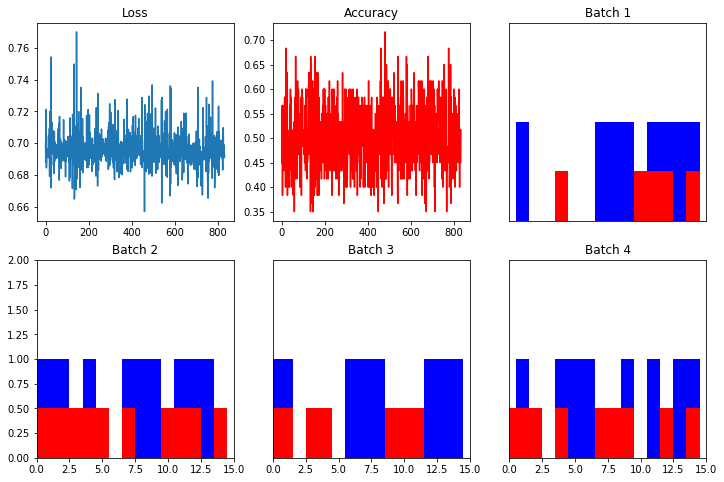

Epoch  5: Average Loss 0.6957, Average Accuracy 0.5058
Epoch  6: Average Loss 0.6955, Average Accuracy 0.5062
Epoch  7: Average Loss 0.6953, Average Accuracy 0.5051
Epoch  8: Average Loss 0.6952, Average Accuracy 0.5026
Epoch  9: Average Loss 0.6950, Average Accuracy 0.5035


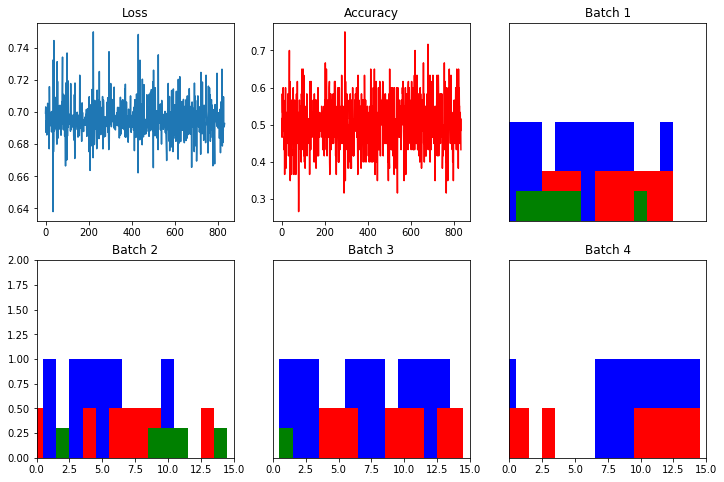

In [83]:
init_state = np.zeros((BATCH_SIZE, state_size), dtype=np.float32)
model = RNN(state_size, state_size, NUM_CLASS, init_state)


for epoch_idx in range(NUM_EPOCH):
    x,y = generateData()
    model.state = np.zeros((BATCH_SIZE, state_size))#model.cell.zero_state(BATCH_SIZE, dtype=tf.float32)
    
    #print("New data, epoch", epoch_idx)
    loss_list = []
    accuracy_list = []
    for batch_idx in range(NUM_BATCH):
        with tf.GradientTape() as t:
            start_idx = batch_idx * TRUNCATED_BACKPROP_LENGTH
            end_idx = start_idx + TRUNCATED_BACKPROP_LENGTH

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            # Unpack columns
            inputs_series = tf.reshape(tf.transpose(batchX.astype(np.float32),(0,1)),(-1,BATCH_SIZE))
            labels_series = tf.unstack(batchY, axis=1)

            # Forward pass
            y_pred = model(inputs_series)
            stack_y_pred = tf.reshape(y_pred, (-1,2))
            stack_y = tf.reshape(tf.one_hot(tf.stack(labels_series), NUM_CLASS), (-1,2))
            losses = Loss(stack_y_pred, stack_y)
            accuracy = Accuracy(stack_y_pred, stack_y)

        delta = t.gradient(losses, [model.W2, model.b2] + model.cell.variables)
        model.W2.assign_sub(LERNING_RATE * delta[0])
        model.b2.assign_sub(LERNING_RATE * delta[1])

        for i in range(len(model.cell.variables)):
            model.cell.variables[i].assign_sub(LERNING_RATE * delta[i+2])
        
        loss_list.append(losses)
        accuracy_list.append(accuracy)
    print('Epoch %2d: Average Loss %.4f, Average Accuracy %.4f'%(epoch_idx, np.mean(loss_list), np.mean(accuracy_list)))    
    if (epoch_idx+1)%5==0:
        x_test, y_test = generateData(total_series_length=BATCH_SIZE*TRUNCATED_BACKPROP_LENGTH)
        y_pred = model(tf.reshape(tf.transpose(x_test.astype(np.float32),(0,1)),(-1,BATCH_SIZE,1)))
        plot(loss_list, accuracy_list, y_pred, x_test, y_test)